In [3]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display

print("버전: ", tf.__version__)
print("즉시 실행 모드: ", tf.executing_eagerly())
print("GPU ", "사용 가능" if tf.config.experimental.list_physical_devices("GPU") else "사용 불가능")


버전:  2.1.0
즉시 실행 모드:  True
GPU  사용 불가능


In [2]:
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util



In [4]:
# patch tf1 into `utils.ops`
utils_ops.tf = tf.compat.v1

# Patch the location of gfile
tf.gfile = tf.io.gfile



In [5]:

model_name = 'ssd_mobilenet_v1_coco_2017_11_17'
model_dir = f"./data/{model_name}/saved_model"
model = tf.saved_model.load(str(model_dir))
model = model.signatures['serving_default']
print(f'{model_name} load ok')
print(model.inputs)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
ssd_mobilenet_v1_coco_2017_11_17 load ok
[<tf.Tensor 'image_tensor:0' shape=(None, None, None, 3) dtype=uint8>]


In [6]:

category_index = label_map_util.create_category_index_from_labelmap('./data/mscoco_label_map.pbtxt', use_display_name=True)
print(category_index)

{1: {'id': 1, 'name': 'person'}, 2: {'id': 2, 'name': 'bicycle'}, 3: {'id': 3, 'name': 'car'}, 4: {'id': 4, 'name': 'motorcycle'}, 5: {'id': 5, 'name': 'airplane'}, 6: {'id': 6, 'name': 'bus'}, 7: {'id': 7, 'name': 'train'}, 8: {'id': 8, 'name': 'truck'}, 9: {'id': 9, 'name': 'boat'}, 10: {'id': 10, 'name': 'traffic light'}, 11: {'id': 11, 'name': 'fire hydrant'}, 13: {'id': 13, 'name': 'stop sign'}, 14: {'id': 14, 'name': 'parking meter'}, 15: {'id': 15, 'name': 'bench'}, 16: {'id': 16, 'name': 'bird'}, 17: {'id': 17, 'name': 'cat'}, 18: {'id': 18, 'name': 'dog'}, 19: {'id': 19, 'name': 'horse'}, 20: {'id': 20, 'name': 'sheep'}, 21: {'id': 21, 'name': 'cow'}, 22: {'id': 22, 'name': 'elephant'}, 23: {'id': 23, 'name': 'bear'}, 24: {'id': 24, 'name': 'zebra'}, 25: {'id': 25, 'name': 'giraffe'}, 27: {'id': 27, 'name': 'backpack'}, 28: {'id': 28, 'name': 'umbrella'}, 31: {'id': 31, 'name': 'handbag'}, 32: {'id': 32, 'name': 'tie'}, 33: {'id': 33, 'name': 'suitcase'}, 34: {'id': 34, 'name'

In [22]:
#image_path = '../res/chinagirl.jpg'
image_path = '../res/3.jpg'
print('load image')
image_np = np.array(Image.open(image_path))


load image


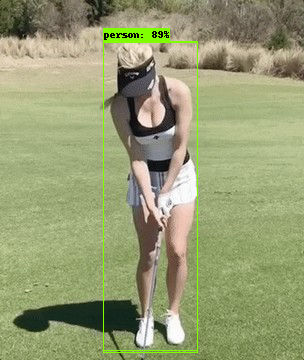

In [25]:
image = np.asarray(image_np)
  # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
input_tensor = tf.convert_to_tensor(image)
  # The model expects a batch of images, so add an axis with `tf.newaxis`.
input_tensor = input_tensor[tf.newaxis,...]

  # Run inference
output_dict = model(input_tensor)

num_detections = int(output_dict.pop('num_detections'))

output_dict = {key:value[0, :num_detections].numpy() for key,value in output_dict.items()}
output_dict['num_detections'] = num_detections

# detection_classes should be ints.
output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)


vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      line_thickness=1)

display(Image.fromarray(image_np))
